### The goal is to make a robo-advisor to invest in mutual funds by predicting the market trend.


## Index
### 1. market prediction
- environmental factors
- macroeconomic variables
- KOSPI index
- turning point of market cycle
  - peak and trough value

- input
  - time series index data
  - macroeconomic indices
- pre-training
  - VAE (variational autoencoder)
- classify and predict market situation
  - LSTM

### 2. automated investment


### 3. fund-selection strategies



# 1. Market Prediction
## 1) Labeling market trend
### Purpose : forcast the Korea bull and bear market trend using the monthly KOSPI index
Identify the turning point of market cycle by peak and trough value.
- P_t > (1+lambda_1)*P^min
  => P_t = a peak
- P_t < (1-lamda_2)*P^max 
  => P_t = a trough
- bull markets : trough -> peak
- bear markets : peak -> trough
- lambda_1 = 0.20, lambda_2 = 0.15
- sliding window = 8 months

Constraints

- peaks and troughs in the first and last six months out
- if fall or rise doesn't exceed 20%, duration must be greater than 4 months
- duration of a complete cycle consists of 2 phases must be greater than 16 months


Flat market
- the period of the market that cannot be classified as bull or bear

### (1) KOSPI Index OHLVC 데이터 조회

In [ ]:
pip install -U finance-datareader

     |████████████████████████████████| 48 kB 2.5 MB/s 


In [ ]:
import FinanceDataReader as fdr

In [ ]:
ks_df = fdr.DataReader('KS11', '20071101', '20220131')
ks_df

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2007-11-01,2063.14,2085.33,2085.45,2048.68,401960000.0,-0.0008
2007-11-02,2019.34,2014.65,2049.62,2014.65,388390000.0,-0.0212
2007-11-05,2015.76,2025.04,2027.21,1992.24,300210000.0,-0.0018
2007-11-06,2054.24,2023.41,2055.53,2020.24,312250000.0,0.0191
2007-11-07,2043.19,2074.18,2085.03,2043.19,339570000.0,-0.0054
...,...,...,...,...,...,...
2022-01-24,2792.00,2823.76,2828.11,2780.68,473990000.0,-0.0149
2022-01-25,2720.39,2786.41,2789.62,2703.99,639960000.0,-0.0256
2022-01-26,2709.24,2729.75,2744.14,2708.10,472650000.0,-0.0041


In [ ]:
ks_df = ks_df.resample('M').last().copy()
ks_df

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2007-11-30,1906.00,1886.58,1918.12,1884.92,339310000.0,0.0151
2007-12-31,1897.13,1892.56,1911.67,1890.81,229420000.0,-0.0060
2008-01-31,1624.68,1582.19,1630.12,1570.87,334130000.0,0.0224
2008-02-29,1711.62,1717.69,1721.85,1708.21,315820000.0,-0.0141
2008-03-31,1703.99,1705.17,1709.31,1685.19,291720000.0,0.0013
...,...,...,...,...,...,...
2021-09-30,3068.82,3054.87,3079.43,3046.43,885820000.0,0.0028
2021-10-31,2970.68,3025.67,3030.17,2965.40,545830000.0,-0.0129
2021-11-30,2839.01,2932.71,2942.93,2822.73,983560000.0,-0.0242


In [ ]:
ks_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 171 entries, 2007-11-30 to 2022-01-31
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   171 non-null    float64
 1   Open    171 non-null    float64
 2   High    171 non-null    float64
 3   Low     171 non-null    float64
 4   Volume  171 non-null    float64
 5   Change  171 non-null    float64
dtypes: float64(6)
memory usage: 9.4 KB


In [ ]:
# Peak: P_t > (1+lambda1)*P^min
lambda1 = 0.20
peak_pr = (1+lambda1)*ks_df['Close'].rolling(8).min()
peak_pr

Date
2007-11-30         NaN
2007-12-31         NaN
2008-01-31         NaN
2008-02-29         NaN
2008-03-31         NaN
                ...   
2021-09-30    3615.540
2021-10-31    3564.816
2021-11-30    3406.812
2021-12-31    3406.812
2022-01-31    3196.008
Freq: M, Name: Close, Length: 171, dtype: float64

종가가 peak_pr 값보다 높으면 고점

In [ ]:
# Trough: P_t < (1-lambda2)*P^max
lambda2 = 0.15
trough_pr = (1-lambda2)*ks_df['Close'].rolling(8).max()
trough_pr

Date
2007-11-30         NaN
2007-12-31         NaN
2008-01-31         NaN
2008-02-29         NaN
2008-03-31         NaN
                ...   
2021-09-30    2802.178
2021-10-31    2802.178
2021-11-30    2802.178
2021-12-31    2802.178
2022-01-31    2802.178
Freq: M, Name: Close, Length: 171, dtype: float64

종가가 trough_pr값보다 작으면 저점

지나치게 많은 마켓 시그널을 피하기 위해 몇 가지 제약조건을 둔다.

- 처음과 끝 부분 각각 6개월 동안 발생한 신호는 무시한다.
- 단계(phase)의 기간은 20% 이상 하락하거나 상승하지 않는 한 최소한 4개월 이상이어야 한다.
- 두 단계를 포함하는 전체 사이클 기간은 16개월 이상이어야 한다.


## 2) Market prediction
- input data : time series index data + macroeconomic indices
- pre-training : variational autoencoder (VAE)
- classify and predict market situation : LSTM network

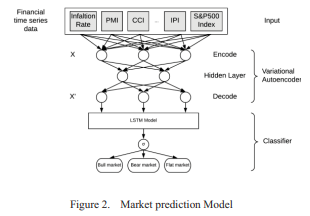

## (1) Information of market
### Macroeconomic Variables
### inf
- 월별 소비자물가 등락률 

### IPI
- 전산업생산지수

### M1g
- M1(평잔)증감률

### M2g 
- M2(평잔)증감률

### M1g - M2g 
- M1증감률과 M2증감률 차이

### BSI
- 기업경기실사지수

### unemp
- 실업률(월)

### CSI 
- 소비자심리지수

### spread_koribor_3m
- KORIBOR 3개월물과 기준금리 스프레드

### spread_koribor_6m
- KORIBOR 6개월물과 기준금리 스프레드

### spread_5y
- 국고채 5년물과 기준금리 스프레드 

### spread_10y 
- 국고채 10년물과 기준금리 스프레드

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Dataframe.xlsx to Dataframe.xlsx


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving BaseRate.xlsx to BaseRate.xlsx


In [ ]:
# Data read
df = pd.read_excel('Dataframe.xlsx')
df

,지수종류,"Inflation Rate(전월비, %)",전산업생산지수(2015=100),M1g(%),M2g(%),M1g-M2g(%),BSI,Unemploymetn Rate(%),CCSI,KORIBOR 3m(%),KORIBOR 6m(%),국고채 5y(%),국고채 10y(%)
0,2008.07,0.7,84.9,1.4,14.8,-13.4,75,3.1,74.5,5.50,5.76,6.020,6.030
1,2008.08,-0.2,82.1,2.2,14.7,-12.5,73,3.1,92.2,5.76,6.08,5.830,5.910
2,2008.09,0.1,84.9,2.7,14.5,-11.8,73,3.0,91.1,5.79,6.16,5.860,5.990
3,2008.10,-0.1,85.3,4.2,14.2,-10.0,64,3.0,78.8,5.97,6.58,5.160,5.530
4,2008.11,-0.3,81.4,5.5,14.0,-8.5,55,3.0,74.1,5.59,6.26,5.170,5.730
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,2021.08,0.5,108.3,20.0,12.5,7.5,87,2.6,102.4,0.79,0.96,1.653,1.905
158,2021.09,0.4,111.0,19.7,12.8,6.9,84,2.7,103.7,0.93,1.09,1.786,2.061
159,2021.10,0.2,112.0,18.0,12.4,5.6,86,2.8,106.7,1.02,1.21,2.154,2.399
160,2021.11,0.5,116.0,17.6,12.9,4.7,86,2.6,107.6,1.20,1.43,2.174,2.355


In [ ]:
br = pd.read_excel('BaseRate.xlsx')
br

,date,base_rate
0,2008/07,5.00
1,2008/08,5.25
2,2008/09,5.25
3,2008/10,4.25
4,2008/11,4.00
...,...,...
157,2021/08,0.75
158,2021/09,0.75
159,2021/10,0.75
160,2021/11,1.00


In [ ]:
df = df.rename(columns={'지수종류':'date',
                        'Inflation Rate(전월비, %)':'inf',
                        '전산업생산지수(2015=100)':'IPI',
                        'Unemploymetn Rate(%)':'unemp',
                        '국고채 5y(%)':'govbond5y(%)',
                        '국고채 10y(%)':'govbond10y(%)'
                        })
df

,date,inf,IPI,M1g(%),M2g(%),M1g-M2g(%),BSI,unemp,CCSI,KORIBOR 3m(%),KORIBOR 6m(%),govbond5y(%),govbond10y(%)
0,2008.07,0.7,84.9,1.4,14.8,-13.4,75,3.1,74.5,5.50,5.76,6.020,6.030
1,2008.08,-0.2,82.1,2.2,14.7,-12.5,73,3.1,92.2,5.76,6.08,5.830,5.910
2,2008.09,0.1,84.9,2.7,14.5,-11.8,73,3.0,91.1,5.79,6.16,5.860,5.990
3,2008.10,-0.1,85.3,4.2,14.2,-10.0,64,3.0,78.8,5.97,6.58,5.160,5.530
4,2008.11,-0.3,81.4,5.5,14.0,-8.5,55,3.0,74.1,5.59,6.26,5.170,5.730
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,2021.08,0.5,108.3,20.0,12.5,7.5,87,2.6,102.4,0.79,0.96,1.653,1.905
158,2021.09,0.4,111.0,19.7,12.8,6.9,84,2.7,103.7,0.93,1.09,1.786,2.061
159,2021.10,0.2,112.0,18.0,12.4,5.6,86,2.8,106.7,1.02,1.21,2.154,2.399
160,2021.11,0.5,116.0,17.6,12.9,4.7,86,2.6,107.6,1.20,1.43,2.174,2.355


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           162 non-null    float64
 1   inf            162 non-null    float64
 2   IPI            162 non-null    float64
 3   M1g(%)         161 non-null    float64
 4   M2g(%)         161 non-null    float64
 5   M1g-M2g(%)     161 non-null    float64
 6   BSI            162 non-null    int64  
 7   unemp          162 non-null    float64
 8   CCSI           162 non-null    float64
 9   KORIBOR 3m(%)  162 non-null    float64
 10  KORIBOR 6m(%)  162 non-null    float64
 11  govbond5y(%)   162 non-null    float64
 12  govbond10y(%)  162 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 16.6 KB


In [ ]:
br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       162 non-null    object 
 1   base_rate  162 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.7+ KB


In [ ]:
df['base_rate'] = br['base_rate']
df

,date,inf,IPI,M1g(%),M2g(%),M1g-M2g(%),BSI,unemp,CCSI,KORIBOR 3m(%),KORIBOR 6m(%),govbond5y(%),govbond10y(%),base_rate
0,2008.07,0.7,84.9,1.4,14.8,-13.4,75,3.1,74.5,5.50,5.76,6.020,6.030,5.00
1,2008.08,-0.2,82.1,2.2,14.7,-12.5,73,3.1,92.2,5.76,6.08,5.830,5.910,5.25
2,2008.09,0.1,84.9,2.7,14.5,-11.8,73,3.0,91.1,5.79,6.16,5.860,5.990,5.25
3,2008.10,-0.1,85.3,4.2,14.2,-10.0,64,3.0,78.8,5.97,6.58,5.160,5.530,4.25
4,2008.11,-0.3,81.4,5.5,14.0,-8.5,55,3.0,74.1,5.59,6.26,5.170,5.730,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,2021.08,0.5,108.3,20.0,12.5,7.5,87,2.6,102.4,0.79,0.96,1.653,1.905,0.75
158,2021.09,0.4,111.0,19.7,12.8,6.9,84,2.7,103.7,0.93,1.09,1.786,2.061,0.75
159,2021.10,0.2,112.0,18.0,12.4,5.6,86,2.8,106.7,1.02,1.21,2.154,2.399,0.75
160,2021.11,0.5,116.0,17.6,12.9,4.7,86,2.6,107.6,1.20,1.43,2.174,2.355,1.00


In [ ]:
df = df.set_index('date')
df

,inf,IPI,M1g(%),M2g(%),M1g-M2g(%),BSI,unemp,CCSI,KORIBOR 3m(%),KORIBOR 6m(%),govbond5y(%),govbond10y(%),base_rate
date,,,,,,,,,,,,,
2008.07,0.7,84.9,1.4,14.8,-13.4,75,3.1,74.5,5.50,5.76,6.020,6.030,5.00
2008.08,-0.2,82.1,2.2,14.7,-12.5,73,3.1,92.2,5.76,6.08,5.830,5.910,5.25
2008.09,0.1,84.9,2.7,14.5,-11.8,73,3.0,91.1,5.79,6.16,5.860,5.990,5.25
2008.10,-0.1,85.3,4.2,14.2,-10.0,64,3.0,78.8,5.97,6.58,5.160,5.530,4.25
2008.11,-0.3,81.4,5.5,14.0,-8.5,55,3.0,74.1,5.59,6.26,5.170,5.730,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021.08,0.5,108.3,20.0,12.5,7.5,87,2.6,102.4,0.79,0.96,1.653,1.905,0.75
2021.09,0.4,111.0,19.7,12.8,6.9,84,2.7,103.7,0.93,1.09,1.786,2.061,0.75
2021.10,0.2,112.0,18.0,12.4,5.6,86,2.8,106.7,1.02,1.21,2.154,2.399,0.75


In [ ]:
df['spread_br-koribor3m'] = df['base_rate']-df['KORIBOR 3m(%)']
df['spread_br-koribor6m'] = df['base_rate']-df['KORIBOR 6m(%)']
df['spread_br-govbond5y'] = df['base_rate']-df['govbond5y(%)']
df['spread_br-govbond10y'] = df['base_rate']-df['govbond10y(%)']
df

,inf,IPI,M1g(%),M2g(%),M1g-M2g(%),BSI,unemp,CCSI,KORIBOR 3m(%),KORIBOR 6m(%),govbond5y(%),govbond10y(%),base_rate,spread_br-koribor3m,spread_br-koribor6m,spread_br-govbond5y,spread_br-govbond10y
date,,,,,,,,,,,,,,,,,
2008.07,0.7,84.9,1.4,14.8,-13.4,75,3.1,74.5,5.50,5.76,6.020,6.030,5.00,-0.50,-0.76,-1.020,-1.030
2008.08,-0.2,82.1,2.2,14.7,-12.5,73,3.1,92.2,5.76,6.08,5.830,5.910,5.25,-0.51,-0.83,-0.580,-0.660
2008.09,0.1,84.9,2.7,14.5,-11.8,73,3.0,91.1,5.79,6.16,5.860,5.990,5.25,-0.54,-0.91,-0.610,-0.740
2008.10,-0.1,85.3,4.2,14.2,-10.0,64,3.0,78.8,5.97,6.58,5.160,5.530,4.25,-1.72,-2.33,-0.910,-1.280
2008.11,-0.3,81.4,5.5,14.0,-8.5,55,3.0,74.1,5.59,6.26,5.170,5.730,4.00,-1.59,-2.26,-1.170,-1.730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021.08,0.5,108.3,20.0,12.5,7.5,87,2.6,102.4,0.79,0.96,1.653,1.905,0.75,-0.04,-0.21,-0.903,-1.155
2021.09,0.4,111.0,19.7,12.8,6.9,84,2.7,103.7,0.93,1.09,1.786,2.061,0.75,-0.18,-0.34,-1.036,-1.311
2021.10,0.2,112.0,18.0,12.4,5.6,86,2.8,106.7,1.02,1.21,2.154,2.399,0.75,-0.27,-0.46,-1.404,-1.649


In [ ]:
input_var_df = df.drop(columns=['KORIBOR 3m(%)', 'KORIBOR 6m(%)', 'govbond5y(%)', 'govbond10y(%)', 'base_rate'])
input_var_df

,inf,IPI,M1g(%),M2g(%),M1g-M2g(%),BSI,unemp,CCSI,spread_br-koribor3m,spread_br-koribor6m,spread_br-govbond5y,spread_br-govbond10y
date,,,,,,,,,,,,
2008.07,0.7,84.9,1.4,14.8,-13.4,75,3.1,74.5,-0.50,-0.76,-1.020,-1.030
2008.08,-0.2,82.1,2.2,14.7,-12.5,73,3.1,92.2,-0.51,-0.83,-0.580,-0.660
2008.09,0.1,84.9,2.7,14.5,-11.8,73,3.0,91.1,-0.54,-0.91,-0.610,-0.740
2008.10,-0.1,85.3,4.2,14.2,-10.0,64,3.0,78.8,-1.72,-2.33,-0.910,-1.280
2008.11,-0.3,81.4,5.5,14.0,-8.5,55,3.0,74.1,-1.59,-2.26,-1.170,-1.730
...,...,...,...,...,...,...,...,...,...,...,...,...
2021.08,0.5,108.3,20.0,12.5,7.5,87,2.6,102.4,-0.04,-0.21,-0.903,-1.155
2021.09,0.4,111.0,19.7,12.8,6.9,84,2.7,103.7,-0.18,-0.34,-1.036,-1.311
2021.10,0.2,112.0,18.0,12.4,5.6,86,2.8,106.7,-0.27,-0.46,-1.404,-1.649


In [ ]:
ks_df['Close']

Date
2008-07-31    1594.67
2008-08-31    1474.24
2008-09-30    1448.06
2008-10-31    1113.06
2008-11-30    1076.07
               ...   
2021-09-30    3068.82
2021-10-31    2970.68
2021-11-30    2839.01
2021-12-31    2977.65
2022-01-31    2663.34
Freq: M, Name: Close, Length: 163, dtype: float64

In [ ]:
input_df = input_var_df.join(ks_df['Close'], how='outer')
input_df

,inf,IPI,M1g(%),M2g(%),M1g-M2g(%),BSI,unemp,CCSI,spread_br-koribor3m,spread_br-koribor6m,spread_br-govbond5y,spread_br-govbond10y,Close
2008-07-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1594.67
2008-08-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1474.24
2008-09-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1448.06
2008-10-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1113.06
2008-11-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1076.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021.08,0.5,108.3,20.0,12.5,7.5,87.0,2.6,102.4,-0.04,-0.21,-0.903,-1.155,NaN
2021.09,0.4,111.0,19.7,12.8,6.9,84.0,2.7,103.7,-0.18,-0.34,-1.036,-1.311,NaN
2021.1,0.2,112.0,18.0,12.4,5.6,86.0,2.8,106.7,-0.27,-0.46,-1.404,-1.649,NaN
2021.11,0.5,116.0,17.6,12.9,4.7,86.0,2.6,107.6,-0.20,-0.43,-1.174,-1.355,NaN


In [ ]:
date_list = pd.date_range('2008.07', '2022.01', freq='M')
date_list

DatetimeIndex(['2008-07-31', '2008-08-31', '2008-09-30', '2008-10-31',
               '2008-11-30', '2008-12-31', '2009-01-31', '2009-02-28',
               '2009-03-31', '2009-04-30',
               ...
               '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30',
               '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31',
               '2021-11-30', '2021-12-31'],
              dtype='datetime64[ns]', length=162, freq='M')

In [ ]:
input_var_df['monthly_date'] = date_list
input_var_df

,inf,IPI,M1g(%),M2g(%),M1g-M2g(%),BSI,unemp,CCSI,spread_br-koribor3m,spread_br-koribor6m,spread_br-govbond5y,spread_br-govbond10y,monthly_date
date,,,,,,,,,,,,,
2008.07,0.7,84.9,1.4,14.8,-13.4,75,3.1,74.5,-0.50,-0.76,-1.020,-1.030,2008-07-31
2008.08,-0.2,82.1,2.2,14.7,-12.5,73,3.1,92.2,-0.51,-0.83,-0.580,-0.660,2008-08-31
2008.09,0.1,84.9,2.7,14.5,-11.8,73,3.0,91.1,-0.54,-0.91,-0.610,-0.740,2008-09-30
2008.10,-0.1,85.3,4.2,14.2,-10.0,64,3.0,78.8,-1.72,-2.33,-0.910,-1.280,2008-10-31
2008.11,-0.3,81.4,5.5,14.0,-8.5,55,3.0,74.1,-1.59,-2.26,-1.170,-1.730,2008-11-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021.08,0.5,108.3,20.0,12.5,7.5,87,2.6,102.4,-0.04,-0.21,-0.903,-1.155,2021-08-31
2021.09,0.4,111.0,19.7,12.8,6.9,84,2.7,103.7,-0.18,-0.34,-1.036,-1.311,2021-09-30
2021.10,0.2,112.0,18.0,12.4,5.6,86,2.8,106.7,-0.27,-0.46,-1.404,-1.649,2021-10-31


In [ ]:
input_df = input_var_df.set_index('monthly_date')
input_df

,inf,IPI,M1g(%),M2g(%),M1g-M2g(%),BSI,unemp,CCSI,spread_br-koribor3m,spread_br-koribor6m,spread_br-govbond5y,spread_br-govbond10y
monthly_date,,,,,,,,,,,,
2008-07-31,0.7,84.9,1.4,14.8,-13.4,75,3.1,74.5,-0.50,-0.76,-1.020,-1.030
2008-08-31,-0.2,82.1,2.2,14.7,-12.5,73,3.1,92.2,-0.51,-0.83,-0.580,-0.660
2008-09-30,0.1,84.9,2.7,14.5,-11.8,73,3.0,91.1,-0.54,-0.91,-0.610,-0.740
2008-10-31,-0.1,85.3,4.2,14.2,-10.0,64,3.0,78.8,-1.72,-2.33,-0.910,-1.280
2008-11-30,-0.3,81.4,5.5,14.0,-8.5,55,3.0,74.1,-1.59,-2.26,-1.170,-1.730
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0.5,108.3,20.0,12.5,7.5,87,2.6,102.4,-0.04,-0.21,-0.903,-1.155
2021-09-30,0.4,111.0,19.7,12.8,6.9,84,2.7,103.7,-0.18,-0.34,-1.036,-1.311
2021-10-31,0.2,112.0,18.0,12.4,5.6,86,2.8,106.7,-0.27,-0.46,-1.404,-1.649


In [ ]:
input_df = input_df.join(ks_df['Close'], how='inner')
input_df

,inf,IPI,M1g(%),M2g(%),M1g-M2g(%),BSI,unemp,CCSI,spread_br-koribor3m,spread_br-koribor6m,spread_br-govbond5y,spread_br-govbond10y,Close
2008-07-31,0.7,84.9,1.4,14.8,-13.4,75,3.1,74.5,-0.50,-0.76,-1.020,-1.030,1594.67
2008-08-31,-0.2,82.1,2.2,14.7,-12.5,73,3.1,92.2,-0.51,-0.83,-0.580,-0.660,1474.24
2008-09-30,0.1,84.9,2.7,14.5,-11.8,73,3.0,91.1,-0.54,-0.91,-0.610,-0.740,1448.06
2008-10-31,-0.1,85.3,4.2,14.2,-10.0,64,3.0,78.8,-1.72,-2.33,-0.910,-1.280,1113.06
2008-11-30,-0.3,81.4,5.5,14.0,-8.5,55,3.0,74.1,-1.59,-2.26,-1.170,-1.730,1076.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0.5,108.3,20.0,12.5,7.5,87,2.6,102.4,-0.04,-0.21,-0.903,-1.155,3199.27
2021-09-30,0.4,111.0,19.7,12.8,6.9,84,2.7,103.7,-0.18,-0.34,-1.036,-1.311,3068.82
2021-10-31,0.2,112.0,18.0,12.4,5.6,86,2.8,106.7,-0.27,-0.46,-1.404,-1.649,2970.68
2021-11-30,0.5,116.0,17.6,12.9,4.7,86,2.6,107.6,-0.20,-0.43,-1.174,-1.355,2839.01


## (2) 데이터 정규화

In [ ]:
# 숫자 단위가 클수록 계산에 소요되는 시간이 늘어나므로 데이터를 0~1 사이 작은 단위로 변환 후 계산하여 소요 시간 단축
def MinMaxScaler(data):
  """최솟값과 최댓값을 이용하여 0~1 값으로 변환"""
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  return numerator / (denominator + 1e-7) # 0으로 나누기 에러가 발생하지 않도록 매우 작은 값을 더해서 나누기

In [ ]:
scaled_df = MinMaxScaler(input_df).dropna()
target_sr = scaled_df[['Close']]

x = scaled_df.values.tolist()
y = target_sr.values.tolist()

## (3) 모델링


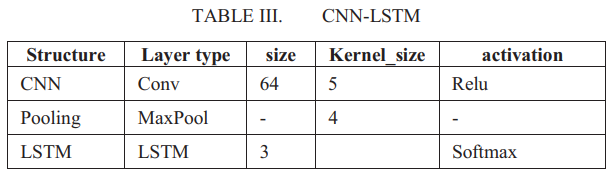
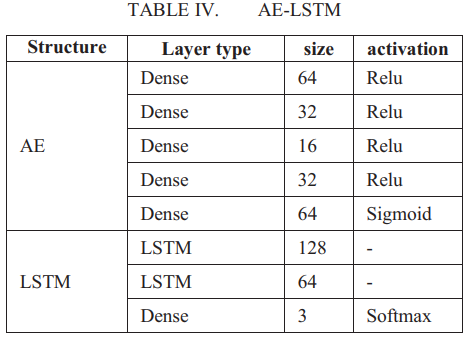
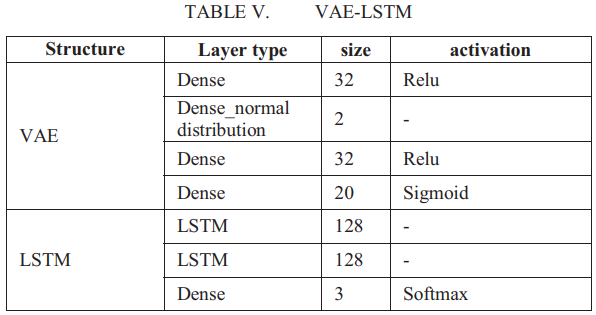


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

# VAE - LSTM
N_1~N_i for training and predict N_i+1 at time t=0. 

At t=1, retrain the model with N_i+1 added back to training set and predict N_i+2

- sliding window size : 20 (consecutive months)
- layers : 2

## VAE
Compress data into a smaller representation

= less dimension than the original data

### layers
- a dense layer
- a normal distribution layer

### two hidden vectors
- mean
- standard deviation

### sampling layer

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_std_dev) to sample z."""

    def call(self, inputs):
        z_mean, z_std_dev = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_std_dev) * epsilon

### Encoder

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(13, 1))
v = layers.Dense(32, activation='relu')(encoder_inputs)
v = layers.Flatten()(v)
z_mean = layers.Dense(latent_dim, name="mean")(v)
z_std_dev = layers.Dense(latent_dim, name="standard_deviation")(v)
z = Sampling()([z_mean, z_std_dev])
v = layers.Dense(32, activation='relu')(v)
v = layers.Dense(20, activation='sigmoid')(v)
encoder = keras.Model(encoder_inputs, [z_mean, z_std_dev, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13, 1)]      0           []                               
                                                                                                  
 dense (Dense)                  (None, 13, 32)       64          ['input_1[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 416)          0           ['dense[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            834         ['flatten[0][0]']                
                                                                                            

### Decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim))
v = layers.Dense(13 * 20, activation="sigmoid")(latent_inputs)
v = layers.Reshape((13, 20))(v)
v = layers.Dense(32, activation='relu')(v)
decoder_outputs = layers.Dense(32, activation='relu')(v)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 260)               780       
                                                                 
 reshape (Reshape)           (None, 13, 20)            0         
                                                                 
 dense_4 (Dense)             (None, 13, 32)            672       
                                                                 
 dense_5 (Dense)             (None, 13, 32)            1056      
                                                                 
Total params: 2,508
Trainable params: 2,508
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_std_dev, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_std_dev - tf.square(z_mean) - tf.exp(z_std_dev))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## LSTM
can solve gradient vanishing problem caused by RNN

### layers
- two LSTM layers
- one dense layer

In [ ]:
data_x = []
data_y = []
window_size = 20 # 20달 간의 마켓 데이터
for i in range(len(y) - window_size):
  _x = x[i : i + window_size] # 다음 달 종가(i+window_size)는 미포함
  _y = y[i + window_size] # 다음 달 종가
  data_x.append(_x)
  data_y.append(_y)
print(_x, "->", _y)

[[0.2631578808864273, 0.636363635158402, 0.5056179756343896, 0.4576271147658719, 0.6222222202469136, 0.0681818180268595, 0.5161290156087415, 0.2034220528452053, 0.7443181395273784, 0.8015266869646305, 0.7460267763780999, 0.7345779022029788, 0.3096322163136736], [0.15789472853185635, 0.4999999990530303, 0.5917602974091374, 0.5169491481614479, 0.6730158708793147, 0.0, 0.5161290156087415, 0.06273764246627819, 0.8011363181172545, 0.8396946244391366, 0.7478965176722807, 0.7294372097013743, 0.39600205939175787], [0.31578945706371275, 0.5094696960047922, 0.6816479375219178, 0.5847457577563919, 0.7238095215117158, 0.04545454535123967, 0.6129032060353804, 0.1882129273988346, 0.7443181395273782, 0.8015266869646304, 0.7108133153376966, 0.6915584228474453, 0.43273117988795334], [0.5263157617728547, 0.6477272715005165, 0.7565543042825681, 0.5847457577563919, 0.7873015848022172, 0.11363636337809917, 0.5483870790842877, 0.2661596953114835, 0.8806817681430813, 0.8893129431559946, 0.711436562435757, 0.

- 이전 20달 동안 마켓 데이터 중 가장 마지막 달 종가(정규화되어 0에서 1 사이의값) = 0.8541
- 20달 동안의 마켓 데이터에 매핑되는 다음 달 종가 = 0.7951

### (3-1) 훈련 데이터셋, 테스트 데이터셋 분리

논문의 경우
- training set : 1995/01 ~ 2011/12 (17년)
- test set : 2012/01 ~ 2016/12 (5년)

즉, 학습 데이터로 17/22=77.27%, 평가 데이터로 5/22=22.72%를 설정했다.

따라서 논문에서 설정한 조건과 최대한 비슷하게 맞추기 위해서 국내 데이터를 대상으로 학습 데이터를 77%, 평가 데이터를 23%로 설정했다.  

In [ ]:
# train data set (77%)
train_size = int(len(data_y) * 0.77)
train_x = np.array(data_x[0:train_size])
train_y = np.array(data_y[0:train_size])

# test data set (23%)
test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size:len(data_x)])
test_y = np.array(data_y[train_size:len(data_y)])

### (3-2) 모델 생성

In [ ]:
# 시퀀셜 모델 객체 생성
model = Sequential()
"""
window_size = 20 으로 설정했으므로, (20,13) 입력 형태를 가지는 LSTM층 추가
전체 유닛 개수 = 13
활성화함수 = relu
"""
# Input Layer
model.add(LSTM(units=13, activation='relu', return_sequences=True,
               input_shape=(window_size, 13)))

# 드롭아웃 = 15%로 지정
"""
드롭아웃층 : 입력값의 일부분을 선택 -> 그 값을 0으로 치환 -> 다음층으로 출력
=> 훈련 데이터 늘리지 않고도 과적합 방지 가능(원활한 학습 가능케 함)
"""
model.add(Dropout(0.15))

# Hidden Layer
model.add(LSTM(units=13, activation='relu'))
model.add(Dropout(0.15))

# 유닛이 하나인 Output Layer 추가
model.add(Dense(units=1, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 13)            1404      
                                                                 
 dropout (Dropout)           (None, 20, 13)            0         
                                                                 
 lstm_1 (LSTM)               (None, 13)                1404      
                                                                 
 dropout_1 (Dropout)         (None, 13)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 14        
                                                                 
Total params: 2,822
Trainable params: 2,822
Non-trainable params: 0
_________________________________________________________________


### (3-3) 학습 및 예측

In [ ]:
"""
최적화 도구 : adam
손실 함수 : 평균 제곱 오차(MSE)
모형 평가 : accuracy
"""
model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', 
                      min_delta=0, 
                      patience=14, 
                      verbose=0, 
                      mode='auto', 
                      baseline=None, 
                      restore_best_weights=False)

# 훈련용 데이터셋으로 모델 학습
"""
epochs = 전체 데이터셋에 대한 학습 횟수
batch_size = 한 번에 제공되는 훈련 데이터 개수
"""
history = model.fit(train_x, train_y, 
                    epochs=28, 
                    batch_size=3,
                    shuffle=False,
                    validation_split=0.20,
                    # verbose=0,
                    callbacks=[early]
                    )

# 테스트 데이터셋을 이용하여 예측치 데이터셋 생성
pred_y = model.predict(test_x)

Epoch 1/28
29/29 [==============================] - 4s 33ms/step - loss: 0.3548 - accuracy: 0.0000e+00 - val_loss: 0.1857 - val_accuracy: 0.0000e+00
Epoch 2/28
29/29 [==============================] - 1s 17ms/step - loss: 0.3548 - accuracy: 0.0000e+00 - val_loss: 0.1857 - val_accuracy: 0.0000e+00
Epoch 3/28
29/29 [==============================] - 0s 16ms/step - loss: 0.3548 - accuracy: 0.0000e+00 - val_loss: 0.1857 - val_accuracy: 0.0000e+00
Epoch 4/28
29/29 [==============================] - 0s 16ms/step - loss: 0.3548 - accuracy: 0.0000e+00 - val_loss: 0.1857 - val_accuracy: 0.0000e+00
Epoch 5/28
29/29 [==============================] - 1s 18ms/step - loss: 0.3548 - accuracy: 0.0000e+00 - val_loss: 0.1857 - val_accuracy: 0.0000e+00
Epoch 6/28
29/29 [==============================] - 0s 17ms/step - loss: 0.3548 - accuracy: 0.0000e+00 - val_loss: 0.1857 - val_accuracy: 0.0000e+00
Epoch 7/28
29/29 [==============================] - 0s 16ms/step - loss: 0.3548 - accuracy: 0.0000e+00 - v

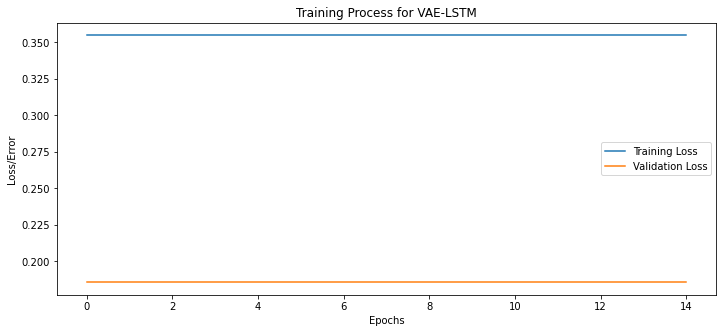

In [ ]:
def plot_history(history):
  plt.figure(figsize=(26,5))
  ax = plt.subplot(1,2,1)
  plt.plot(history.history["loss"], label="Training Loss")
  plt.plot(history.history["val_loss"], label="Validation Loss")
  plt.title("Training Process for VAE-LSTM")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Loss/Error')
plot_history(history)

### 예측치와 실제 종가를 그래프로 비교

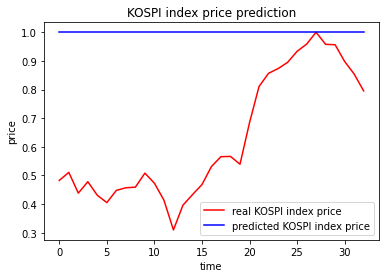

In [ ]:
plt.figure()
plt.plot(test_y, color='r', label='real KOSPI index price')
plt.plot(pred_y, color='b', label='predicted KOSPI index price')
plt.title('KOSPI index price prediction')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

### (3-4) 다음 달 예측 종가 출력
변환 전의 마지막 달 종가(input_df['Close'][-1])와 변환 후의 마지막 달 종가(target_sr['Close'][-1])의 관계식(input_df['Close'][-1] : target_sr['Close'][-1] = y : pred_y[-1])을 이용해서 다음달 예측 가격 y 구하기

In [ ]:
print("KOSPI index price next month :", input_df['Close'][-1]*pred_y[-1]/target_sr['Close'][-1])

KOSPI index price next month : [3744.9902]


# 2. Automated Investment
## Investment Strategy
### - fund ranking
  - filter by P-value and the coefficient of determination (R^2)
  - rank by alpha and beta
  - group into 100 percentiles


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/ZEROIN_FDTFN202.csv.zip > /dev/null

In [ ]:
import pandas as pd
chunksize = 10 ** 7
fund_df = []
for chunk in enumerate(pd.read_csv('/content/ZEROIN_FDTFN202.csv', chunksize=chunksize)):
  fund_df.append(chunk)
  break 
fund_df
# chunk = pd.read_csv('/content/ZEROIN_FDTFN202.csv', chunksize=1000000000)


[(0,           GIJUN_YMD GUBUN  TERM       FUND_CD GIGAN_SUIK_RANK  \
  0        2000-01-04     H     1  KR5101100018              \N   
  1        2000-01-04     H     1  KR5101100034              \N   
  2        2000-01-04     H     1  KR5101100109              \N   
  3        2000-01-04     H     1  KR5101100224              \N   
  4        2000-01-04     H     1  KR5101100497              \N   
  ...             ...   ...   ...           ...             ...   
  9999995  2010-10-25     W     0  KR5104687540              88   
  9999996  2010-10-25     W     0  KR5104692144              \N   
  9999997  2010-10-25     W     0  KR5104709849              \N   
  9999998  2010-10-25     W     0  KR5104709856             394   
  9999999  2010-10-25     W     0  KR5104709864             409   
  
          GIGAN_SUIK_RANK2  SILH_SUIK_RT  BM_SUIK_RT BM_SUIK_RANK BM_SUIK_RANK2  \
  0                     \N      1.027509    1.000000           \N            \N   
  1                     

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving woori_irp_fund.xlsx to woori_irp_fund.xlsx


In [ ]:
import pandas as pd
fund_df = pd.read_excel('woori_irp_fund.xlsx', index_col=0)
fund_df

,K55207BU0715,K55370BU1789,K55235BW6898,K55307D05118,K55213BX5796,K55105BV3695,K55229BU7300,K55101BT7462,K55301BV2426,K55232BU5747,...,K55105D00562,K55234CJ0997,K55105D17574,K55107D40440,K55210BU2435,K55105BT9928,K55301BU6253,K55207CP6031,K55101BT7397,K55223BT1450
2017-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,999.880000
2017-08-31,1023.120000,1001.110000,NaN,NaN,NaN,1010.200000,1051.750000,995.310000,NaN,1000.100000,...,NaN,NaN,NaN,NaN,996.210000,992.250000,1003.840000,NaN,983.510000,995.760000
2017-09-30,1036.970000,1020.800000,999.150000,NaN,NaN,1019.070000,1042.220000,1034.870000,958.070000,989.950000,...,NaN,NaN,NaN,NaN,1031.210000,1007.400000,1016.500000,NaN,994.450000,1011.270000
2017-10-31,1091.460000,1055.180000,1060.440000,NaN,NaN,1077.780719,1100.815645,1062.840000,996.700000,981.900000,...,NaN,NaN,NaN,NaN,1040.080000,1024.670000,1044.020000,NaN,1016.850000,1027.810000
2017-11-30,1092.980000,1089.580000,1095.730000,NaN,988.260000,1120.302326,1091.524669,1182.740000,992.520000,987.330000,...,NaN,NaN,NaN,NaN,1018.630000,1036.590000,1058.110000,NaN,1031.610000,1036.080000
2017-12-31,1087.650000,1092.080000,1099.300000,NaN,1013.830000,1107.871856,1061.611527,1235.620000,1007.410000,988.910000,...,NaN,NaN,NaN,NaN,1022.340000,1042.980000,1054.120000,NaN,1038.880000,1044.420000
2018-01-31,1116.370000,1165.550647,1153.620000,NaN,1068.250000,1259.537586,1126.738368,1377.420000,1055.167132,965.720000,...,NaN,NaN,NaN,NaN,1093.360000,1094.360000,1103.220000,NaN,1100.070000,1086.550000
2018-02-28,1060.610000,1149.370499,1136.670000,NaN,1053.580000,1237.336748,1086.954189,1375.340000,990.784498,973.340000,...,NaN,NaN,NaN,NaN,1060.590000,1072.190000,1083.210000,NaN,1067.100000,1060.310000
2018-03-31,1053.350000,1085.319914,1089.680000,NaN,1016.620000,1156.593697,1081.283593,1422.460000,946.328619,982.640000,...,NaN,NaN,NaN,NaN,1003.200000,1035.200000,1048.053829,NaN,1034.689648,1027.330000
2018-04-30,1079.030000,1119.080222,1080.090000,NaN,975.080000,1148.863405,1034.758706,1297.090000,976.633469,980.170000,...,NaN,NaN,NaN,NaN,1027.280000,1042.599142,1055.774468,NaN,1043.192274,1040.910000


### p-value로 필터링


In [ ]:
from scipy.stats import normaltest
normaltest(fund_df.pct_change().dropna())

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


NormaltestResult(statistic=array([ 1.70474635, 16.16052617,  5.70116105,  6.05533211,  2.28090983,
        3.69956248,  2.27233584,  0.8518261 ,  0.43984785,  0.19000113,
        0.47987998,  0.31530006,  0.67387922,  6.53067721,  6.775315  ,
        6.94796116,  3.97766044, 13.43471093, 13.52111002, 14.57749813,
       13.33606825, 14.11986165, 19.17509565,  6.99583897, 11.64585716]), pvalue=array([4.26401805e-01, 3.09589576e-04, 5.78107505e-02, 4.84285358e-02,
       3.19673565e-01, 1.57271567e-01, 3.21046946e-01, 6.53173133e-01,
       8.02579851e-01, 9.09372422e-01, 7.86675067e-01, 8.54148658e-01,
       7.13951953e-01, 3.81840037e-02, 3.37877321e-02, 3.09934131e-02,
       1.36855423e-01, 1.20973317e-03, 1.15858597e-03, 6.83182134e-04,
       1.27089471e-03, 8.58837500e-04, 6.85773792e-05, 3.02602749e-02,
       2.95892700e-03]))

In [ ]:
sub_df = fund_df.iloc[:, [1, 2, 3, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24]]
sub_df

,K55370BU1789,K55235BW6898,K55307D05118,K55102BT6570,K55213DA8043,K55105D00562,K55105D17574,K55107D40440,K55210BU2435,K55105BT9928,K55301BU6253,K55207CP6031,K55101BT7397,K55223BT1450
2017-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,999.880000
2017-08-31,1001.110000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,996.210000,992.250000,1003.840000,NaN,983.510000,995.760000
2017-09-30,1020.800000,999.150000,NaN,NaN,NaN,NaN,NaN,NaN,1031.210000,1007.400000,1016.500000,NaN,994.450000,1011.270000
2017-10-31,1055.180000,1060.440000,NaN,NaN,NaN,NaN,NaN,NaN,1040.080000,1024.670000,1044.020000,NaN,1016.850000,1027.810000
2017-11-30,1089.580000,1095.730000,NaN,NaN,NaN,NaN,NaN,NaN,1018.630000,1036.590000,1058.110000,NaN,1031.610000,1036.080000
2017-12-31,1092.080000,1099.300000,NaN,NaN,NaN,NaN,NaN,NaN,1022.340000,1042.980000,1054.120000,NaN,1038.880000,1044.420000
2018-01-31,1165.550647,1153.620000,NaN,NaN,NaN,NaN,NaN,NaN,1093.360000,1094.360000,1103.220000,NaN,1100.070000,1086.550000
2018-02-28,1149.370499,1136.670000,NaN,NaN,NaN,NaN,NaN,NaN,1060.590000,1072.190000,1083.210000,NaN,1067.100000,1060.310000
2018-03-31,1085.319914,1089.680000,NaN,NaN,NaN,NaN,NaN,NaN,1003.200000,1035.200000,1048.053829,NaN,1034.689648,1027.330000
2018-04-30,1119.080222,1080.090000,NaN,NaN,NaN,NaN,NaN,NaN,1027.280000,1042.599142,1055.774468,NaN,1043.192274,1040.910000


### 알파와 베타로 순위 설정

In [ ]:
sub_df_rtn = sub_df.pct_change()
sub_df_rtn

,K55370BU1789,K55235BW6898,K55307D05118,K55102BT6570,K55213DA8043,K55105D00562,K55105D17574,K55107D40440,K55210BU2435,K55105BT9928,K55301BU6253,K55207CP6031,K55101BT7397,K55223BT1450
2017-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004120
2017-09-30,0.019668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.035133,0.015268,0.012612,NaN,0.011123,0.015576
2017-10-31,0.033679,0.061342,NaN,NaN,NaN,NaN,NaN,NaN,0.008602,0.017143,0.027073,NaN,0.022525,0.016356
2017-11-30,0.032601,0.033279,NaN,NaN,NaN,NaN,NaN,NaN,-0.020623,0.011633,0.013496,NaN,0.014515,0.008046
2017-12-31,0.002294,0.003258,NaN,NaN,NaN,NaN,NaN,NaN,0.003642,0.006164,-0.003771,NaN,0.007047,0.008050
2018-01-31,0.067276,0.049413,NaN,NaN,NaN,NaN,NaN,NaN,0.069468,0.049263,0.046579,NaN,0.058900,0.040338
2018-02-28,-0.013882,-0.014693,NaN,NaN,NaN,NaN,NaN,NaN,-0.029972,-0.020258,-0.018138,NaN,-0.029971,-0.024150
2018-03-31,-0.055727,-0.041340,NaN,NaN,NaN,NaN,NaN,NaN,-0.054111,-0.034499,-0.032456,NaN,-0.030372,-0.031104
2018-04-30,0.031106,-0.008801,NaN,NaN,NaN,NaN,NaN,NaN,0.024003,0.007148,0.007367,NaN,0.008218,0.013219


In [ ]:
rtn_df = sub_df_rtn.iloc[0:-1].join(ks_df['Change'], how='outer').dropna()
rtn_df

,K55370BU1789,K55235BW6898,K55307D05118,K55102BT6570,K55213DA8043,K55105D00562,K55105D17574,K55107D40440,K55210BU2435,K55105BT9928,K55301BU6253,K55207CP6031,K55101BT7397,K55223BT1450,Change
2020-12-31,0.040316,0.058097,0.037696,-0.001885,-0.001542,-0.009200,0.017235,0.019996,0.017845,0.029358,0.031376,0.024447,0.031796,0.031485,0.0188
2021-01-31,-0.014808,0.049981,0.048458,0.003749,0.008038,0.016409,0.012014,0.018943,0.040682,0.006793,0.036302,0.023247,0.013174,0.014460,-0.0303
2021-02-28,0.023200,0.046872,0.095222,0.052156,0.002957,0.055583,0.016047,0.027150,0.018816,0.026295,0.032566,0.017271,0.020516,0.023576,-0.0280
2021-03-31,0.001894,0.009696,-0.034173,0.024408,0.019268,0.029220,-0.011636,-0.001263,0.003158,-0.007342,-0.005647,0.002377,-0.001122,-0.005505,-0.0028
2021-04-30,0.081013,0.048100,0.031716,0.043834,0.036642,0.054203,0.030547,0.032130,0.016904,0.033238,0.026663,0.019600,0.034372,0.031903,-0.0083
2021-05-31,-0.004516,-0.010235,-0.003214,0.010202,0.025373,0.015961,-0.001901,0.005548,0.012725,0.009765,0.003466,0.003631,0.002644,0.003533,0.0048
2021-06-30,0.054425,0.024377,0.048266,0.038296,0.030763,0.039574,0.015526,0.014964,0.015367,0.012636,0.015689,0.021671,0.008411,0.012705,0.0030
2021-07-31,0.045647,0.005994,-0.011441,0.034569,-0.005324,0.035454,0.008899,0.007955,0.008714,0.002600,0.002026,0.004517,0.002105,0.002840,-0.0124
2021-08-31,0.018336,0.023153,0.049931,0.013061,0.000035,0.003427,0.016852,0.014770,0.017727,0.015317,0.015229,0.008267,0.013916,0.009778,0.0175
2021-09-30,-0.052165,-0.018271,-0.031050,-0.035939,-0.003846,-0.033541,-0.024839,-0.023293,-0.017298,-0.022525,-0.017579,-0.023752,-0.015113,-0.023695,0.0028


In [ ]:
import statsmodels.api as sm
X = rtn_df['Change']
y = rtn_df['K55370BU1789']

X_sm = sm.add_constant(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
model = sm.OLS(y, X_sm)

In [ ]:
results = model.fit()

In [ ]:
results.summary()

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           K55370BU1789   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.380
Date:                Thu, 24 Mar 2022   Prob (F-statistic):              0.263
Time:                        12:54:16   Log-Likelihood:                 21.704
No. Observations:                  14   AIC:                            -39.41
Df Residuals:                      12   BIC:                            -38.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.015      0.431      0.674      -0.027       0.040
Change        -1.0988      0.935     -1.175      0.263      -3.136       0.939
==============================================================================
Omnibus:                        6.033   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                3.048
Skew:                          -1.075   Prob(JB):                        0.218
Kurtosis:                       3.774   Cond. No.                         63.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- K55101BT7397 beta: -0.2586 alpha: 0.0044
- K55102BT6570 beta: -0.9817 alpha: 0.0104
- K55105BT9928 beta: -0.4125 alpha: 0.0035
- K55105D00562 beta: -1.3615 alpha: 0.0122
- K55105D17574 beta: -0.4737 alpha: 0.0020
- K55107D40440 beta: -0.5437 alpha: 0.0047
- K55207CP6031 beta: -0.5320 alpha: 0.0022
- K55210BU2435 beta: -0.5800 alpha: 0.0062
- K55213DA8043 beta: -0.3680 alpha: 0.0064
- K55223BT1450 beta: -0.4500 alpha: 0.0034
- K55235BW6898 beta: -0.7116 alpha: 0.0123
- K55301BU6253 beta: -0.6893 alpha: 0.0050
- K55307D05118 beta: -1.9916 alpha: 0.0115
- K55370BU1789 beta: -1.0988 alpha: 0.0066


### - fund selection
### bear market
the lower the beta value, the smaller the fund affected by systematic risk

highest alpha at equal weights

### bull market
enjoy systematic profit when beta value is higher
= group with highest beta is selected

### alpha = excess return 
(after removing the systematic risk factor)


### ! select the top or last fifth centile of data sorted by alpha or beta

- 1) Bull-Bear switching filtered by alpha-beta (BBS(a-B))

- 2) Bull-Bear switching filtered by beta (BBS(B))


### - 1-year buy-and-hold
  - equal weights
  - held for 12 months

In [ ]:
bear_port = fund_df[['K55307D05118', 'K55105D00562', 'K55370BU1789', 'K55102BT6570', 'K55235BW6898']]
bull_port = fund_df[['K55101BT7397', 'K55213DA8043', 'K55105BT9928', 'K55223BT1450', 'K55105D17574']]

In [ ]:
bear_port

,K55307D05118,K55105D00562,K55370BU1789,K55102BT6570,K55235BW6898
2017-07-31,NaN,NaN,NaN,NaN,NaN
2017-08-31,NaN,NaN,1001.110000,NaN,NaN
2017-09-30,NaN,NaN,1020.800000,NaN,999.150000
2017-10-31,NaN,NaN,1055.180000,NaN,1060.440000
2017-11-30,NaN,NaN,1089.580000,NaN,1095.730000
2017-12-31,NaN,NaN,1092.080000,NaN,1099.300000
2018-01-31,NaN,NaN,1165.550647,NaN,1153.620000
2018-02-28,NaN,NaN,1149.370499,NaN,1136.670000
2018-03-31,NaN,NaN,1085.319914,NaN,1089.680000
2018-04-30,NaN,NaN,1119.080222,NaN,1080.090000


In [ ]:
bull_port

,K55101BT7397,K55213DA8043,K55105BT9928,K55223BT1450,K55105D17574
2017-07-31,NaN,NaN,NaN,999.880000,NaN
2017-08-31,983.510000,NaN,992.250000,995.760000,NaN
2017-09-30,994.450000,NaN,1007.400000,1011.270000,NaN
2017-10-31,1016.850000,NaN,1024.670000,1027.810000,NaN
2017-11-30,1031.610000,NaN,1036.590000,1036.080000,NaN
2017-12-31,1038.880000,NaN,1042.980000,1044.420000,NaN
2018-01-31,1100.070000,NaN,1094.360000,1086.550000,NaN
2018-02-28,1067.100000,NaN,1072.190000,1060.310000,NaN
2018-03-31,1034.689648,NaN,1035.200000,1027.330000,NaN
2018-04-30,1043.192274,NaN,1042.599142,1040.910000,NaN


In [ ]:
market_signal = pd.DataFrame([peak_pr, trough_pr]).T
market_signal.columns = ['peak', 'trough']
market_signal

,peak,trough
Date,,
2007-11-30,NaN,NaN
2007-12-31,NaN,NaN
2008-01-31,NaN,NaN
2008-02-29,NaN,NaN
2008-03-31,NaN,NaN
...,...,...
2021-09-30,3615.540,2802.178
2021-10-31,3564.816,2802.178
2021-11-30,3406.812,2802.178


In [ ]:
df = ks_df.join(market_signal, how='outer')
df = df.loc['2008-07-31': '2022-01-31']
df

,Close,Open,High,Low,Volume,Change,peak,trough
Date,,,,,,,,
2008-07-31,1594.67,1583.99,1600.15,1577.81,233010000.0,0.0108,1913.604,1612.5605
2008-08-31,1474.24,1488.25,1496.14,1470.87,242100000.0,0.0001,1769.088,1574.2170
2008-09-30,1448.06,1383.97,1448.06,1376.72,412810000.0,-0.0057,1737.672,1574.2170
2008-10-31,1113.06,1083.14,1158.66,1061.46,864750000.0,0.0261,1335.672,1574.2170
2008-11-30,1076.07,1066.84,1084.03,1061.52,555250000.0,0.0118,1291.284,1574.2170
...,...,...,...,...,...,...,...,...
2021-09-30,3068.82,3054.87,3079.43,3046.43,885820000.0,0.0028,3615.540,2802.1780
2021-10-31,2970.68,3025.67,3030.17,2965.40,545830000.0,-0.0129,3564.816,2802.1780
2021-11-30,2839.01,2932.71,2942.93,2822.73,983560000.0,-0.0242,3406.812,2802.1780


In [ ]:
df['mkt_signal'] = np.nan
for i in range(0, len(df)):
  if df['Close'].iloc[i] > df['peak'].iloc[i]:
    df['mkt_signal'].iloc[i] = 0
  elif df['Close'].iloc[i] < df['trough'].iloc[i]:
    df['mkt_signal'].iloc[i] = 1
df['mkt_signal'] = df['mkt_signal'].ffill()
df

,Close,Open,High,Low,Volume,Change,peak,trough,mkt_signal
Date,,,,,,,,,
2008-07-31,1594.67,1583.99,1600.15,1577.81,233010000.0,0.0108,1913.604,1612.5605,1.0
2008-08-31,1474.24,1488.25,1496.14,1470.87,242100000.0,0.0001,1769.088,1574.2170,1.0
2008-09-30,1448.06,1383.97,1448.06,1376.72,412810000.0,-0.0057,1737.672,1574.2170,1.0
2008-10-31,1113.06,1083.14,1158.66,1061.46,864750000.0,0.0261,1335.672,1574.2170,1.0
2008-11-30,1076.07,1066.84,1084.03,1061.52,555250000.0,0.0118,1291.284,1574.2170,1.0
...,...,...,...,...,...,...,...,...,...
2021-09-30,3068.82,3054.87,3079.43,3046.43,885820000.0,0.0028,3615.540,2802.1780,0.0
2021-10-31,2970.68,3025.67,3030.17,2965.40,545830000.0,-0.0129,3564.816,2802.1780,0.0
2021-11-30,2839.01,2932.71,2942.93,2822.73,983560000.0,-0.0242,3406.812,2802.1780,0.0


In [ ]:
mkt_df = df[['Close', 'Change', 'peak', 'trough', 'mkt_signal']].copy()
bear_mkt_df = mkt_df.join(bear_port, how='outer')
bull_mkt_df = mkt_df.join(bull_port, how='outer')
total_mkt_df = bear_mkt_df.join(bull_port, how='outer')

In [ ]:
total_mkt_df

,Close,Change,peak,trough,mkt_signal,K55307D05118,K55105D00562,K55370BU1789,K55102BT6570,K55235BW6898,K55101BT7397,K55213DA8043,K55105BT9928,K55223BT1450,K55105D17574
2008-07-31,1594.67,0.0108,1913.604,1612.5605,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-31,1474.24,0.0001,1769.088,1574.2170,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-09-30,1448.06,-0.0057,1737.672,1574.2170,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10-31,1113.06,0.0261,1335.672,1574.2170,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-11-30,1076.07,0.0118,1291.284,1574.2170,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31,2970.68,-0.0129,3564.816,2802.1780,0.0,1818.870000,1349.080000,2239.257868,1265.860483,2450.041044,1437.258815,1177.042484,1390.964308,1369.568232,1108.155243
2021-11-30,2839.01,-0.0242,3406.812,2802.1780,0.0,2021.240000,1355.380000,2296.582421,1273.746833,2427.239586,1411.048047,1169.591898,1370.342169,1356.730058,1106.422255
2021-12-31,2977.65,-0.0052,3406.812,2802.1780,0.0,2129.900000,1450.390000,2389.319787,1325.170293,2520.585592,1434.236420,1192.123669,1406.605931,1386.410693,1124.417120
2022-01-31,2663.34,0.0187,3196.008,2802.1780,1.0,1847.210000,1325.230000,2038.303281,1237.315547,2341.602258,1363.550412,1133.655358,1310.095918,1303.757308,1060.941391


In [ ]:
total_df = total_mkt_df.pct_change()
total_df['bear_rtns'] = 0.2 * (total_df['K55307D05118'] + total_df['K55105D00562'] + total_df['K55370BU1789'] + total_df['K55102BT6570'] + total_df['K55235BW6898'])
total_df['bull_rtns'] = 0.2 * (total_df['K55101BT7397'] + total_df['K55213DA8043'] + total_df['K55105BT9928'] + total_df['K55223BT1450'] + total_df['K55105D17574'])
total_df = total_df.drop(columns=['Change', 'mkt_signal'])
total_df = total_df.join(total_mkt_df['mkt_signal'], how='outer')
total_df

,Close,peak,trough,K55307D05118,K55105D00562,K55370BU1789,K55102BT6570,K55235BW6898,K55101BT7397,K55213DA8043,K55105BT9928,K55223BT1450,K55105D17574,bear_rtns,bull_rtns,mkt_signal
2008-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2008-08-31,-0.075520,-0.075520,-0.023778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2008-09-30,-0.017758,-0.017758,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2008-10-31,-0.231344,-0.231344,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2008-11-30,-0.033233,-0.033233,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31,-0.031980,-0.014029,0.000000,0.013298,0.054735,0.044323,0.040528,0.018442,0.016945,0.035000,0.023618,0.020080,0.018351,0.034265,0.022799,0.0
2021-11-30,-0.044323,-0.044323,0.000000,0.111261,0.004670,0.025600,0.006230,-0.009307,-0.018237,-0.006330,-0.014826,-0.009374,-0.001564,0.027691,-0.010066,0.0
2021-12-31,0.048834,0.000000,0.000000,0.053759,0.070098,0.040381,0.040372,0.038458,0.016433,0.019265,0.026463,0.021877,0.016264,0.048614,0.020060,0.0
2022-01-31,-0.105556,-0.061877,0.000000,-0.132725,-0.086294,-0.146911,-0.066297,-0.071009,-0.049285,-0.049046,-0.068612,-0.059617,-0.056452,-0.100647,-0.056602,1.0


In [ ]:
total_df['port_rtn'] = ""
for i in range(0, len(df)):
  if total_df['mkt_signal'].iloc[i] == 1:
    total_df['port_rtn'].iloc[i] = total_df['bear_rtns'].iloc[i]
  elif total_df['mkt_signal'].iloc[i] == 0:
    total_df['port_rtn'].iloc[i] = total_df['bull_rtns'].iloc[i]
total_df = total_df.dropna()
total_df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Close,peak,trough,K55307D05118,K55105D00562,K55370BU1789,K55102BT6570,K55235BW6898,K55101BT7397,K55213DA8043,K55105BT9928,K55223BT1450,K55105D17574,bear_rtns,bull_rtns,mkt_signal,port_rtn
2020-12-31,0.108874,0.042125,0.108874,0.037696,-0.009200,0.040316,-0.001885,0.058097,0.031796,-0.001542,0.029358,0.031485,0.017235,0.025005,0.021666,0.0,0.021666
2021-01-31,0.035755,0.038791,0.035755,0.048458,0.016409,-0.014808,0.003749,0.049981,0.013174,0.008038,0.006793,0.014460,0.012014,0.020758,0.010896,0.0,0.010896
2021-02-28,0.012345,0.066897,0.012345,0.095222,0.055583,0.023200,0.052156,0.046872,0.020516,0.002957,0.026295,0.023576,0.016047,0.054607,0.017878,0.0,0.017878
2021-03-31,0.016087,0.007904,0.016087,-0.034173,0.029220,0.001894,0.024408,0.009696,-0.001122,0.019268,-0.007342,-0.005505,-0.011636,0.006209,-0.001268,0.0,-0.001268
2021-04-30,0.028235,0.000000,0.028235,0.031716,0.054203,0.081013,0.043834,0.048100,0.034372,0.036642,0.033238,0.031903,0.030547,0.051773,0.033341,0.0,0.033341
2021-05-31,0.017809,0.000000,0.017809,-0.003214,0.015961,-0.004516,0.010202,-0.010235,0.002644,0.025373,0.009765,0.003533,-0.001901,0.001640,0.007883,0.0,0.007883
2021-06-30,0.028952,0.142995,0.028952,0.048266,0.039574,0.054425,0.038296,0.024377,0.008411,0.030763,0.012636,0.012705,0.015526,0.040988,0.016008,0.0,0.016008
2021-07-31,-0.028623,0.108874,0.000000,-0.011441,0.035454,0.045647,0.034569,0.005994,0.002105,-0.005324,0.002600,0.002840,0.008899,0.022045,0.002224,0.0,0.002224
2021-08-31,-0.000952,0.035755,0.000000,0.049931,0.003427,0.018336,0.013061,0.023153,0.013916,0.000035,0.015317,0.009778,0.016852,0.021582,0.011180,0.0,0.01118
2021-09-30,-0.040775,0.012345,0.000000,-0.031050,-0.033541,-0.052165,-0.035939,-0.018271,-0.015113,-0.003846,-0.022525,-0.023695,-0.024839,-0.034193,-0.018003,0.0,-0.018003


In [ ]:
total_df['port_rtn'] = total_df['port_rtn']+1
total_df['port_rtn'].iloc[0] = 100
total_df['port_rtn'] = total_df['port_rtn'].cumprod()

total_df['Close'] = total_df['Close']+1
total_df['Close'].iloc[0] = 100
total_df['Close'] = total_df['Close'].cumprod()

total_df['mkt_neutral'] = 0.5*(total_df['bear_rtns']+total_df['bull_rtns'])
total_df['mkt_neutral'] = total_df['mkt_neutral']+1
total_df['mkt_neutral'].iloc[0] = 100
total_df['mkt_neutral'] = total_df['mkt_neutral'].cumprod()

total_df['bear_rtns'] = total_df['bear_rtns']+1
total_df['bear_rtns'].iloc[0] = 100
total_df['bear_rtns'] = total_df['bear_rtns'].cumprod()

total_df['bull_rtns'] = total_df['bull_rtns']+1
total_df['bull_rtns'].iloc[0] = 100
total_df['bull_rtns'] = total_df['bull_rtns'].cumprod()

compare_df = total_df[['Close', 'bear_rtns', 'bull_rtns', 'mkt_signal', 'port_rtn', 'mkt_neutral']].copy()
compare_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

,Close,bear_rtns,bull_rtns,mkt_signal,port_rtn,mkt_neutral
2020-12-31,100.000000,100.000000,100.000000,0.0,100,100.000000
2021-01-31,103.575468,102.075776,101.089587,0.0,101.089587,101.582682
2021-02-28,104.854061,107.649812,102.896903,0.0,102.896903,105.264302
2021-03-31,106.540872,108.318232,102.766467,0.0,102.766467,105.524388
2021-04-30,109.549082,113.926200,106.192753,0.0,106.192753,110.015167
2021-05-31,111.500033,114.113005,107.029833,0.0,107.029833,110.538968
2021-06-30,114.728186,118.790225,108.743177,0.0,108.743177,113.689092
2021-07-31,111.444351,121.408903,108.985010,0.0,108.98501,115.068621
2021-08-31,111.338208,124.029117,110.203428,0.0,110.203428,116.953526
2021-09-30,106.798401,119.788188,108.219401,0.0,108.219401,113.901254


## Results and Discussion

- Benchmark Index returns: 92.69
- mkt_signal_switching_portfolio returns: 100.52
- mkt_neutral_portfolio(buy-and-hold) returns: 112.63
- only_bull_mkt_portfolio(buy-and-hold) returns: 105.44
- only_bear_mkt_portfolio(buy-and-hold) returns: 120.08

### It turns out portfolios with funds outperform the benchmark index returns.
### However, there was no meaning in switching funds according to market signals. 
### Just holding bear market funds performed the best for the period of time. 

## 한계
활용할 수 있는 데이터 시계열이 많으면 좀 더 유의미한 결과를 포착할 수 있을지도 모르겠다.